In [1]:
import os, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
MODEL_DIR = "models_regression"
os.makedirs(MODEL_DIR, exist_ok=True)

N_ESTIMATORS = 50      # number of trees (you can increase)
TEST_SIZE = 0.2
RANDOM_STATE = 42
ENSEMBLE_WEIGHTS = None 

In [3]:
# 2️⃣ Load Dataset
# ==============================================================
data = load_diabetes()
X, y = data.data, data.target
feature_names = data.feature_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [4]:
# 3️⃣ Define Models
# ==============================================================
rf = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE, n_jobs=-1)
svr = Pipeline([("scaler", StandardScaler()), ("svr", SVR())])
gbr = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)


In [5]:
# 4️⃣ Train and Save Models
# ==============================================================
print("Training base regressors...")

rf.fit(X_train, y_train)
svr.fit(X_train, y_train)
gbr.fit(X_train, y_train)

joblib.dump(rf, os.path.join(MODEL_DIR, "rf_reg.joblib"))
joblib.dump(svr, os.path.join(MODEL_DIR, "svr_reg.joblib"))
joblib.dump(gbr, os.path.join(MODEL_DIR, "gbr_reg.joblib"))

print("✅ Base models trained and saved in:", MODEL_DIR)

Training base regressors...
✅ Base models trained and saved in: models_regression


In [6]:
# 5️⃣ Load Pretrained Models
# ==============================================================
m_rf = joblib.load(os.path.join(MODEL_DIR, "rf_reg.joblib"))
m_svr = joblib.load(os.path.join(MODEL_DIR, "svr_reg.joblib"))
m_gbr = joblib.load(os.path.join(MODEL_DIR, "gbr_reg.joblib"))


In [7]:
# 6️⃣ Create and Train Voting Regressor
# ==============================================================
estimators = [("rf", m_rf), ("svr", m_svr), ("gbr", m_gbr)]
voting = VotingRegressor(estimators=estimators, weights=ENSEMBLE_WEIGHTS)

print("Training Voting Regressor...")
voting.fit(X_train, y_train)
print("✅ Voting Regressor trained.")

Training Voting Regressor...
✅ Voting Regressor trained.


In [8]:
# 7️⃣ Evaluate Models
# ==============================================================
pred_rf = m_rf.predict(X_test)
pred_svr = m_svr.predict(X_test)
pred_gbr = m_gbr.predict(X_test)
pred_voting = voting.predict(X_test)

def metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),  # fixed error here
        "R2": r2_score(y_true, y_pred)
    }

results = {
    "RandomForest": metrics(y_test, pred_rf),
    "SVR": metrics(y_test, pred_svr),
    "GradientBoosting": metrics(y_test, pred_gbr),
    "VotingRegressor": metrics(y_test, pred_voting)
}

results_df = pd.DataFrame(results).T.round(4)
print("\n📊 Model Performance Summary:")
print(results_df)

results_df.to_csv(os.path.join(MODEL_DIR, "ensemble_metrics.csv"))



📊 Model Performance Summary:
                      MAE        MSE     RMSE      R2
RandomForest      44.7654  3044.1991  55.1743  0.4254
SVR               56.0295  4332.7385  65.8235  0.1822
GradientBoosting  44.0891  2849.6163  53.3818  0.4621
VotingRegressor   45.8094  3015.4405  54.9130  0.4309


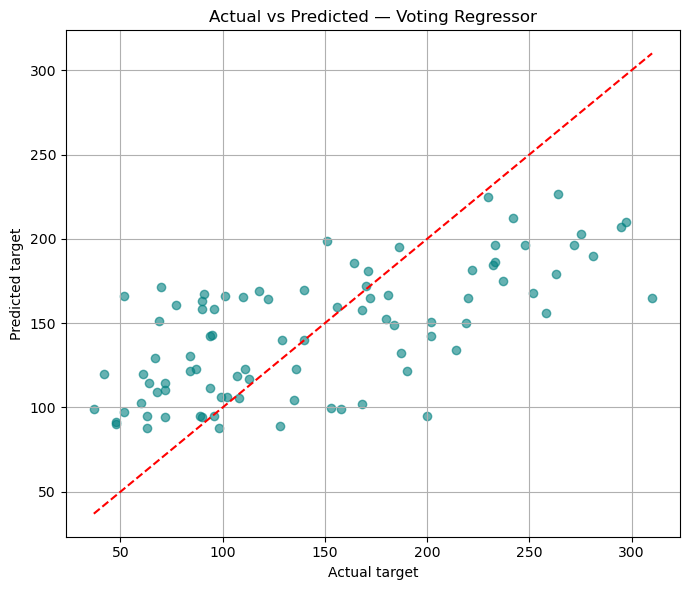

In [9]:
# 8️⃣ Visualization
# ==============================================================

# --- Plot 1: Actual vs Predicted (Voting) ---
plt.figure(figsize=(7,6))
plt.scatter(y_test, pred_voting, alpha=0.6, color="teal")
lims = [min(y_test.min(), pred_voting.min()), max(y_test.max(), pred_voting.max())]
plt.plot(lims, lims, "r--")
plt.xlabel("Actual target")
plt.ylabel("Predicted target")
plt.title("Actual vs Predicted — Voting Regressor")
plt.grid(True)
plt.tight_layout()
plt.show()

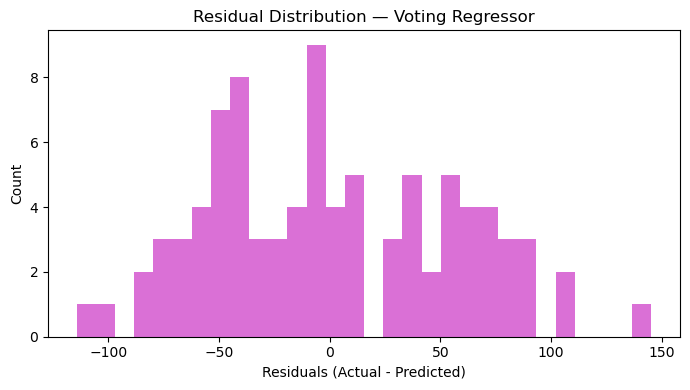

In [10]:
# --- Plot 2: Residual Histogram ---
residuals = y_test - pred_voting
plt.figure(figsize=(7,4))
plt.hist(residuals, bins=30, color="orchid")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Count")
plt.title("Residual Distribution — Voting Regressor")
plt.tight_layout()
plt.show()

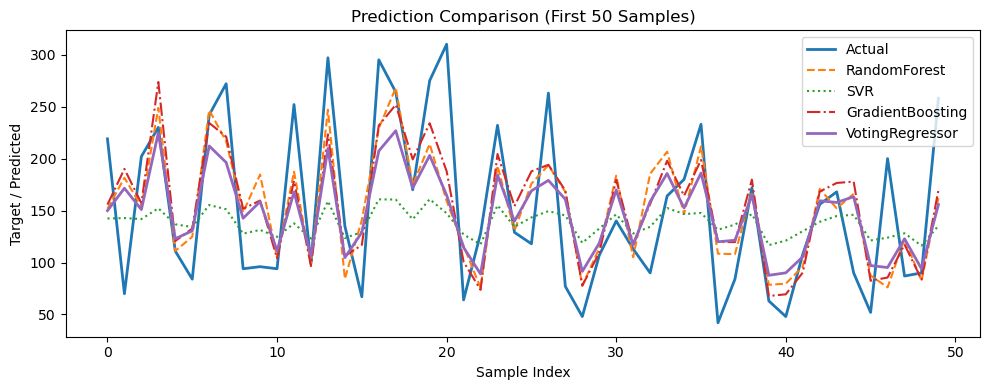

In [11]:
# --- Plot 3: Prediction Comparison ---
N = min(50, len(y_test))
idx = np.arange(N)
plt.figure(figsize=(10,4))
plt.plot(idx, y_test[:N], label="Actual", linewidth=2)
plt.plot(idx, pred_rf[:N], label="RandomForest", linestyle="--")
plt.plot(idx, pred_svr[:N], label="SVR", linestyle=":")
plt.plot(idx, pred_gbr[:N], label="GradientBoosting", linestyle="-.")
plt.plot(idx, pred_voting[:N], label="VotingRegressor", linewidth=2)
plt.xlabel("Sample Index")
plt.ylabel("Target / Predicted")
plt.title("Prediction Comparison (First 50 Samples)")
plt.legend()
plt.tight_layout()
plt.show()

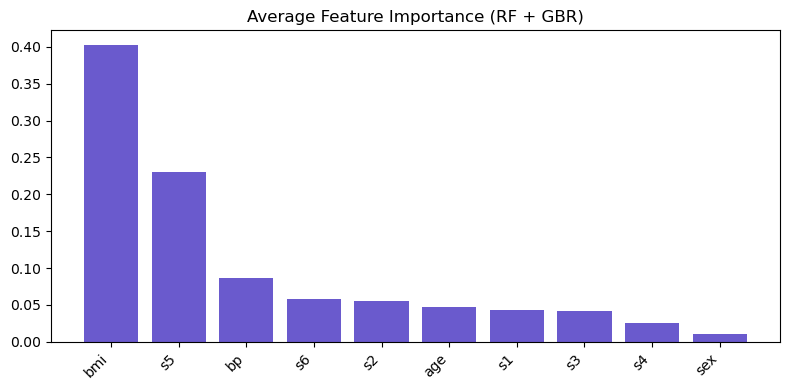

In [12]:
# --- Plot 4: Feature Importances (Average of RF & GBR) ---
try:
    fi_rf = m_rf.feature_importances_
    fi_gbr = m_gbr.feature_importances_
    fi_avg = (fi_rf + fi_gbr) / 2.0
    sorted_idx = np.argsort(fi_avg)[::-1]
    plt.figure(figsize=(8,4))
    plt.bar(range(len(feature_names)), fi_avg[sorted_idx], color="slateblue")
    plt.xticks(range(len(feature_names)), np.array(feature_names)[sorted_idx], rotation=45, ha='right')
    plt.title("Average Feature Importance (RF + GBR)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("⚠️ Could not compute feature importances:", e)

In [13]:
# 9️⃣ Save Predictions
# ==============================================================
out_df = pd.DataFrame({
    "y_true": y_test,
    "pred_rf": pred_rf,
    "pred_svr": pred_svr,
    "pred_gbr": pred_gbr,
    "pred_voting": pred_voting,
    "residual_voting": residuals
})
out_df.to_csv(os.path.join(MODEL_DIR, "test_predictions.csv"), index=False)

print("\n✅ Experiment Completed Successfully!")
print("Results, models, and plots saved in:", MODEL_DIR)


✅ Experiment Completed Successfully!
Results, models, and plots saved in: models_regression
